In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [8]:
!python -V
!conda -V
!conda env list

Python 3.10.12
conda 23.5.2
# conda environments:
#
base                     C:\Users\diana\anaconda3
basecopy                 C:\Users\diana\anaconda3\envs\basecopy
mlenv                 *  C:\Users\diana\anaconda3\envs\mlenv



# Weather Forecast with sklearn
### witty subtitle

In [43]:
#todo: table to csv

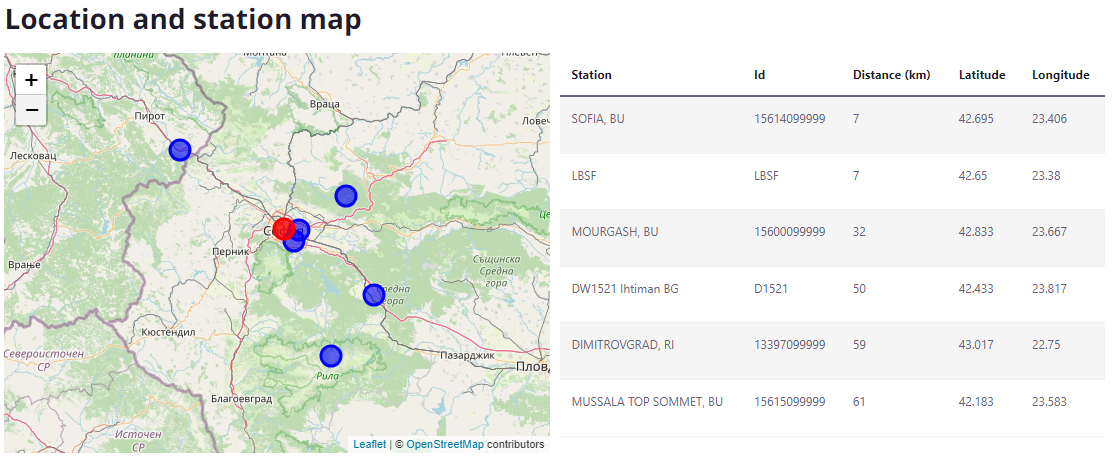

In [9]:
sofia_data = pd.read_csv("data/Sofia 2022-09-01 to 2023-09-09.csv")

In [10]:
sofia_data

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Sofia,2022-09-01,27.0,13.0,19.2,27.1,13.0,19.2,15.0,79.7,...,16.6,7,10,2022-09-01T06:51:12,2022-09-01T20:01:36,0.18,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"15614099999,13397099999,D1521,LBSF,15615099999..."
1,Sofia,2022-09-02,24.0,16.0,18.9,24.0,16.0,18.9,16.4,86.2,...,7.8,6,10,2022-09-02T06:52:16,2022-09-02T19:59:54,0.21,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"15614099999,13397099999,D1521,LBSF,15615099999..."
2,Sofia,2022-09-03,24.0,14.9,17.6,24.0,14.9,17.6,13.8,79.5,...,16.3,7,10,2022-09-03T06:53:20,2022-09-03T19:58:11,0.25,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"15614099999,13397099999,D1521,LBSF,15615099999..."
3,Sofia,2022-09-04,25.0,10.6,16.9,25.0,10.6,16.9,13.1,81.5,...,14.5,7,10,2022-09-04T06:54:24,2022-09-04T19:56:27,0.29,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"15614099999,13397099999,D1521,LBSF,15615099999..."
4,Sofia,2022-09-05,24.0,15.5,18.8,24.0,15.5,18.8,12.2,67.6,...,13.6,7,10,2022-09-05T06:55:28,2022-09-05T19:54:43,0.32,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,rain,"15614099999,13397099999,D1521,LBSF,15615099999..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Sofia,2023-09-05,23.0,13.4,17.7,23.0,13.4,17.7,12.5,73.7,...,8.3,6,10,2023-09-05T06:55:14,2023-09-05T19:55:09,0.68,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"15614099999,D1521,13397099999,LBSF,15615099999..."
370,Sofia,2023-09-06,25.0,14.0,18.9,25.0,14.0,18.9,13.5,72.9,...,5.3,9,10,2023-09-06T06:56:18,2023-09-06T19:53:25,0.71,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,rain,"15614099999,D1521,13397099999,LBSF,15615099999..."
371,Sofia,2023-09-07,24.0,17.0,20.8,24.0,17.0,20.8,13.4,64.3,...,13.3,6,10,2023-09-07T06:57:22,2023-09-07T19:51:40,0.75,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"15614099999,D1521,13397099999,LBSF,15615099999..."
372,Sofia,2023-09-08,26.0,14.0,20.4,26.0,14.0,20.4,11.7,59.4,...,16.9,8,10,2023-09-08T06:58:26,2023-09-08T19:49:55,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"D1521,LBSF"


In [11]:
len(sofia_data.stations[0].split(","))

6